# Brain Tumor Classification

This Notebook looks into using various Python-based machine learning techniques in an attempt to build a machine learning model capable of predicting whether or not someone has Brain tumor based on their MRI Scans.

Our Approach:
1. Problem Statement
2. Data
3. Evaluation
4. Features
4. Modeling
5. Training
6. Testing

## 1. Problem Statement
In a statement,
>Given MRI Scans, Can we predict whether a patient has brain tumor or not?

## 2. Data
The Data used in this project can be found on Kaggle: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

## 3. Evaluation
>Can we reach 98% accuract at predicting whether or not a patient has brain tumor?

## 4. Features
This dataset contains 7023 images of human brain MRI images which are classified into 4 classes:
* glioma
* meningioma
* notumor
* pituitary


## Preaparing the Libraries

In [11]:
#importing all the libraries we need

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.segmentation import slic
import numpy as np
import random
import os

#importing torch libraries

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#importing libraries for visualizing
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

## Creating Training and Testing Data for our model

In [2]:
# Define transformations for training and testing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define directories for training and testing
train_dir = os.path.join('', 'Training')
test_dir = os.path.join('', 'Testing')

# Load datasets
try:
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Data loaders
# train_subset = torch.utils.data.Subset(train_dataset, range(1000)) #Set Range for the data.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class labels
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

## 5. Modeling
How we are going to go forward with modeling
* Preprocess the MRI image by non-local means filter denoises and enhance the contrast.
* AlexNet architecture extract deep features from MRI images avoids over fit problem.
* GRU based on RNN that make it more efficient to vanish the gradient problem.
* Hybrid AlexNet-GRU architecture detects & classify the four classes of brain tumors.

In [3]:
# Load pre-trained AlexNet model
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
alexnet.eval()

# GRU-based classifier
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hybrid model combining AlexNet with GRU
class HybridAlexNetGRU(nn.Module):
    def __init__(self, alexnet, gru_classifier):
        super(HybridAlexNetGRU, self).__init__()
        self.alexnet = alexnet.features
        self.gru = gru_classifier

    def forward(self, x):
        features = self.alexnet(x)
        features = features.view(features.size(0), -1)
        output = self.gru(features.unsqueeze(1))
        return output

# Initialize the model
hidden_size = 1024
output_size = 4
gru_classifier = GRUClassifier(input_size=9216, hidden_size=hidden_size, output_size=output_size)
model = HybridAlexNetGRU(alexnet, gru_classifier)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 6. Training

In [21]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 

        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_samples

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

print("Training complete!")

Epoch [1/20], Loss: 0.3875, Accuracy: 85.35%
Epoch [2/20], Loss: 0.1891, Accuracy: 93.17%
Epoch [3/20], Loss: 0.1519, Accuracy: 94.59%
Epoch [4/20], Loss: 0.1111, Accuracy: 96.06%
Epoch [5/20], Loss: 0.1031, Accuracy: 96.32%
Epoch [6/20], Loss: 0.0825, Accuracy: 96.94%
Epoch [7/20], Loss: 0.0866, Accuracy: 96.88%
Epoch [8/20], Loss: 0.0764, Accuracy: 97.29%
Epoch [9/20], Loss: 0.0533, Accuracy: 98.23%
Epoch [10/20], Loss: 0.0490, Accuracy: 98.37%
Epoch [11/20], Loss: 0.0376, Accuracy: 98.77%
Epoch [12/20], Loss: 0.0493, Accuracy: 98.13%
Epoch [13/20], Loss: 0.0333, Accuracy: 98.84%
Epoch [14/20], Loss: 0.0346, Accuracy: 98.77%
Epoch [15/20], Loss: 0.0307, Accuracy: 98.90%
Epoch [16/20], Loss: 0.0356, Accuracy: 98.90%
Epoch [17/20], Loss: 0.0259, Accuracy: 99.21%
Epoch [18/20], Loss: 0.0232, Accuracy: 99.21%
Epoch [19/20], Loss: 0.0248, Accuracy: 99.11%
Epoch [20/20], Loss: 0.0247, Accuracy: 99.30%
Training complete!


## Save the trained model

In [ ]:
#Saving the model
torch.save(model.state_dict(), 'hybrid_alexnet_gru_model.pth')

## 7. Testing
Result Expected,
>Our goal is to test the predicted outputs with the already known outputs to find out the accuracy of our model

## Load the saved model

In [4]:
model.load_state_dict(torch.load('hybrid_alexnet_gru_model.pth', weights_only=True))
model.eval()  # Set model to evaluation model
model.to(device)

HybridAlexNetGRU(
  (alexnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRUClassifier(
    (gru): GRU(9216, 1024, batch_first=True)
    (fc): Linear(in_features=1024, out_features=4, bias=True)
  )
)

## Validation Loop

In [7]:
# Initialize variables for tracking predictions and true labels
all_labels = []
all_predictions = []

# Testing loop
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collect all labels and predictions for metrics calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')

# Calculate precision, recall, and F1 score for each class
precision = precision_score(all_labels, all_predictions, average=None)
recall = recall_score(all_labels, all_predictions, average=None)
f1 = f1_score(all_labels, all_predictions, average=None)

# Display the results
for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
    print(f"Class {i}: Precision = {p:.2f}, Recall = {r:.2f}, F1-score = {f:.2f}")

Accuracy on test data: 98.25%
Class 0: Precision = 1.00, Recall = 0.95, F1-score = 0.97
Class 1: Precision = 0.95, Recall = 0.98, F1-score = 0.97
Class 2: Precision = 1.00, Recall = 1.00, F1-score = 1.00
Class 3: Precision = 0.98, Recall = 0.99, F1-score = 0.99


## Lime Explainer

  0%|          | 0/1000 [00:00<?, ?it/s]

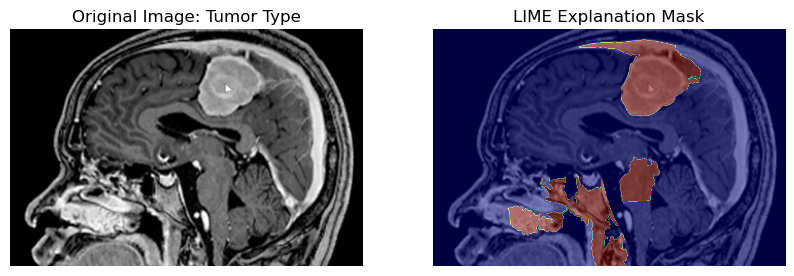

Raw logits: tensor([[-5.6484,  7.2045, -2.1095,  1.0137]], device='cuda:0')
tensor([1], device='cuda:0')
Testing\meningioma\Te-me_0024.jpg
The predicted tumor type is: Meningioma


In [15]:
# Initialize the LIME image explainer
explainer = lime_image.LimeImageExplainer()

def explain_image(model, image, device, transform, segmentation_fn=None):
    
    # Convert image to RGB if it's grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')
    np_image = np.array(image)

    # Create a batch prediction function for LIME
    def batch_predict(images):
        model.eval()
        
        pil_images = [Image.fromarray(img.astype('uint8')) for img in images]

        batch = torch.stack([transform(img) for img in pil_images], dim=0).to(device)
        logits = model(batch)
        return logits.cpu().detach().numpy()

    if segmentation_fn is None:
        segmentation_fn = lambda x: slic(x, n_segments=100, compactness=10, sigma=1)

    # Explain the instance using LIME
    explanation = explainer.explain_instance(np_image, 
                                             batch_predict, 
                                             top_labels=1, 
                                             hide_color=0, 
                                             num_samples=1000,
                                             segmentation_fn=segmentation_fn)

    top_label = explanation.top_labels[0]
    
    # Get the image and mask from the LIME explanation
    temp, mask = explanation.get_image_and_mask(top_label, 
                                                positive_only=True, 
                                                num_features=5, 
                                                hide_rest=False)

    # Plot the original image and LIME explanation
    plt.figure(figsize=(10, 5))
    
    # Original image with title
    plt.subplot(1, 2, 1)
    plt.imshow(np_image)
    plt.title('Original Image: Tumor Type')
    plt.axis('off')
    
    # LIME explanation mask with a colormap overlay
    plt.subplot(1, 2, 2)
    plt.imshow(np_image)
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.title('LIME Explanation Mask')
    plt.axis('off')
    
    # Show the plot
    plt.show()


def predict_tumor_type(image_path, model):
    # Open and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(image)
        print(f'Raw logits: {output}')  # Check output values
        _, predicted = torch.max(output, 1)

    # Map predictions to tumor types
    classes = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    print(predicted)
    tumor_type = classes[predicted.item()]

    return tumor_type

# Load a test image
class_folder = random.choice(os.listdir(test_dir))
class_path = os.path.join(test_dir, class_folder)

test_img_name = random.choice(os.listdir(class_path))
test_img_path = os.path.join(class_path, test_img_name)

test_image = Image.open(test_img_path)

# Explain prediction
explain_image(model, test_image, device, transform)

tumor_type = predict_tumor_type(test_img_path, model)
print(test_img_path)
print(f'The predicted tumor type is: {tumor_type}')